<a href="https://colab.research.google.com/github/cfong32/key-sentence-extraction/blob/main/exp3_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# First we will have to add a "kaggle.json" API key to the colab
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [21]:
! kaggle datasets download -d gowrishankarp/newspaper-text-summarization-cnn-dailymail
! unzip newspaper-text-summarization-cnn-dailymail.zip

newspaper-text-summarization-cnn-dailymail.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  newspaper-text-summarization-cnn-dailymail.zip
  inflating: cnn_dailymail/test.csv  
  inflating: cnn_dailymail/train.csv  
  inflating: cnn_dailymail/validation.csv  


In [31]:
!pip install -q openai sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 81.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import openai
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

[0.06431613 0.10116199 0.10130041 0.88779104 0.5675535  0.86262155
 0.4032426  0.58998287 0.5981258  0.4769823  0.53003603 0.99999976]
[(11, 0.99999976), (3, 0.88779104), (5, 0.86262155), (8, 0.5981258), (7, 0.58998287), (4, 0.5675535), (10, 0.53003603), (9, 0.4769823), (6, 0.4032426), (2, 0.10130041), (1, 0.10116199), (0, 0.06431613)]
[0.88779104, ' 14:11 EST, 25 October 2013 .']
[0.88779104, ' 14:11 EST, 25 October 2013 .', 0.86262155, ' 15:36 EST, 25 October 2013 .']
[0.88779104, ' 14:11 EST, 25 October 2013 .', 0.86262155, ' 15:36 EST, 25 October 2013 .', 0.5981258, ' The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October.']
[0.88779104, ' 14:11 EST, 25 October 2013 .', 0.86262155, ' 15:36 EST, 25 October 2013 .', 0.5981258, ' The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members i

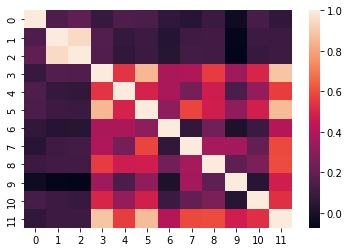

In [16]:
# Minimum length of the sentences to be accounted as sentence.
MIN_LEN = 10

# Top sentences we want to store/account for metric 
rank = 5

# Create an empty dataframe to store these sentences
sentences_by_rank = pd.DataFrame(columns=range(rank*2))

# Create the transformer and read the dataset
model = SentenceTransformer('all-MiniLM-L6-v2')
cnn_df = pd.read_csv("cnn_dailymail/train.csv")

# Loop through the entire dataset:
for i in range(len(cnn_df)):
  # get the paragraph and tokenize it
  paragraph = cnn_df['article'].values[:i+1]
  paragraph = paragraph[0]
  sentences = [s+'.' for s in paragraph.split('.') if len(s.strip()) > MIN_LEN]

  # add the paragraph to last 
  sentences.append(paragraph)

  # encode embeddings
  X = embeddings = model.encode(sentences)
  X.shape

  # apply cossim on the sentences
  cossim = cosine_similarity(X, X)
  #sns.heatmap(cossim)

  # obtain only the last row of arrays (match sentences to the paragraph)
  result = cossim[len(cossim)-1]
  # sort the list in descending order and store the original position
  sorted_result = sorted(enumerate(result), key=lambda x: x[1], reverse=True)
  print(sorted_result)
  
  # loop through the top {rank} of the sentences and store the cossim and sentence of each
  output = []
  for i in range(1,rank+1):
    output.append(sorted_result[i][1])
    output.append(sentences[i])
  sentences_by_rank.append(pd.Series(output, index=sentences_by_rank.columns), ignore_index=True)

  # output the senteces
  print(sentences_by_rank)
